<>:84: SyntaxWarning: invalid escape sequence '\p'
<>:84: SyntaxWarning: invalid escape sequence '\p'
C:\Users\marce\AppData\Local\Temp\ipykernel_3708\2720912282.py:84: SyntaxWarning: invalid escape sequence '\p'
  ax1.set_title(f'Linie strumienia ($\psi$=const) dla Q = {Q}')



--- Rozpoczynanie symulacji dla Q = -1 ---
Iteracja: 1000, Zmiana: 2.81e-06


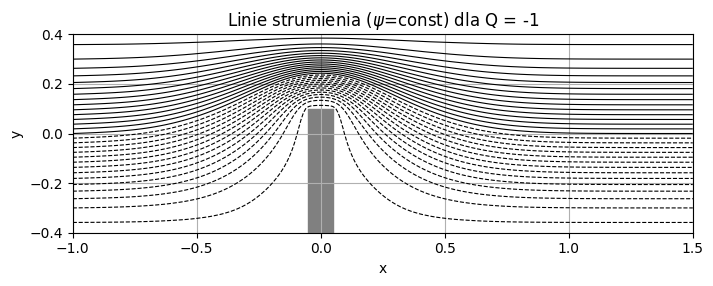

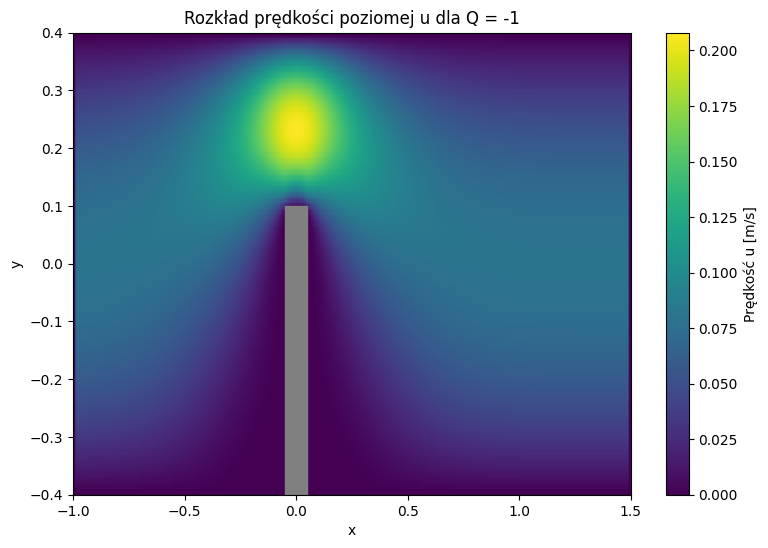

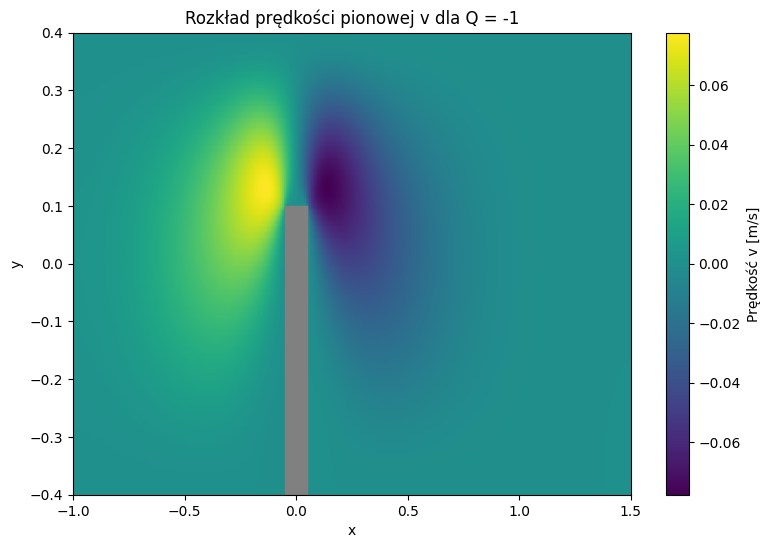


--- Rozpoczynanie symulacji dla Q = -10 ---
Iteracja: 1000, Zmiana: 4.30e-05
Iteracja: 2000, Zmiana: 1.55e-05


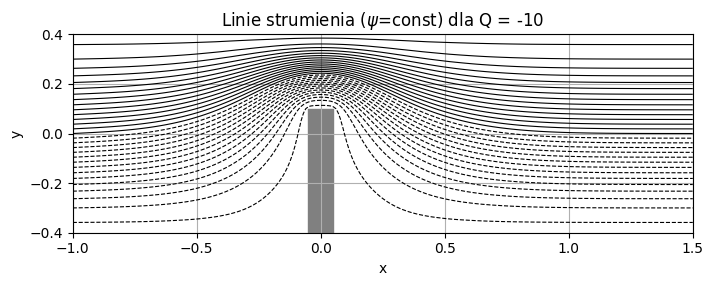

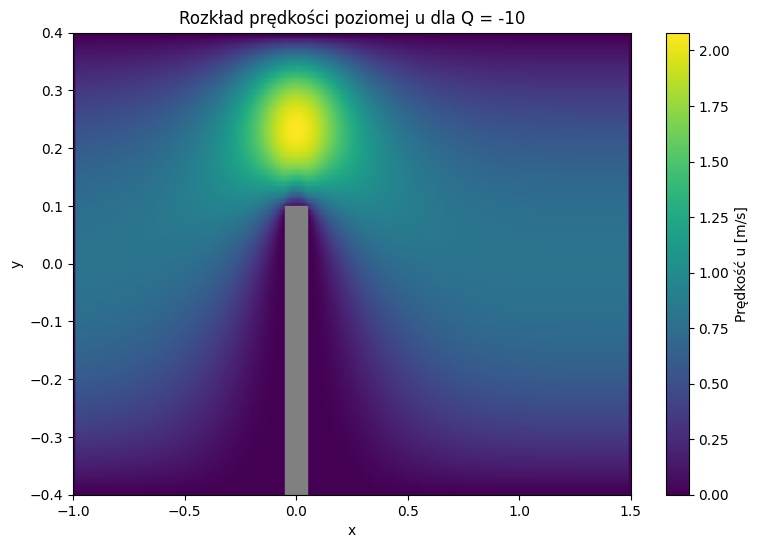

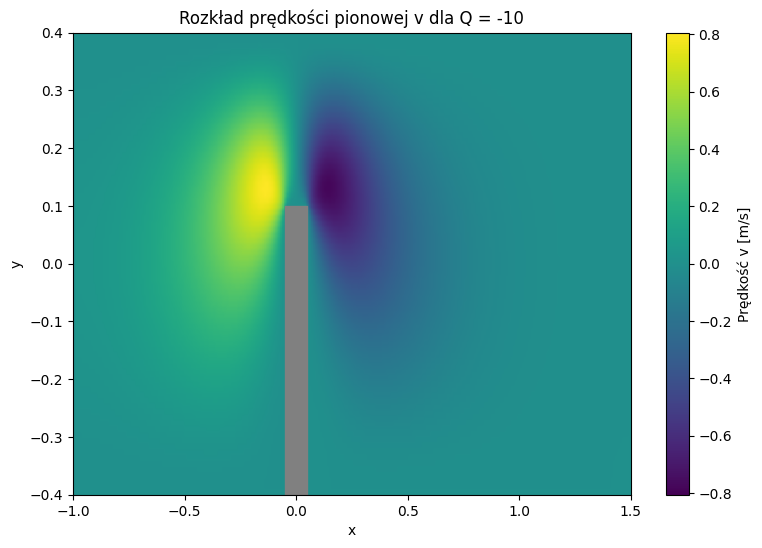


--- Rozpoczynanie symulacji dla Q = -100 ---
Iteracja: 1000, Zmiana: 1.33e-03
Iteracja: 2000, Zmiana: 4.08e-04


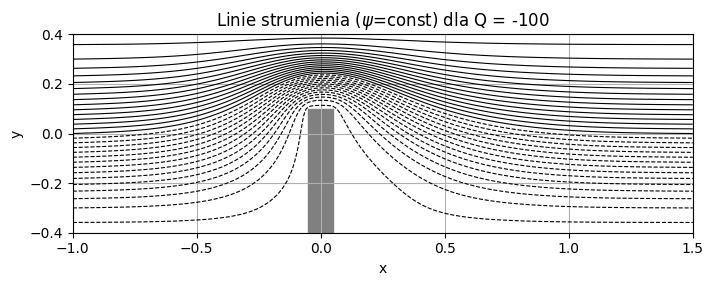

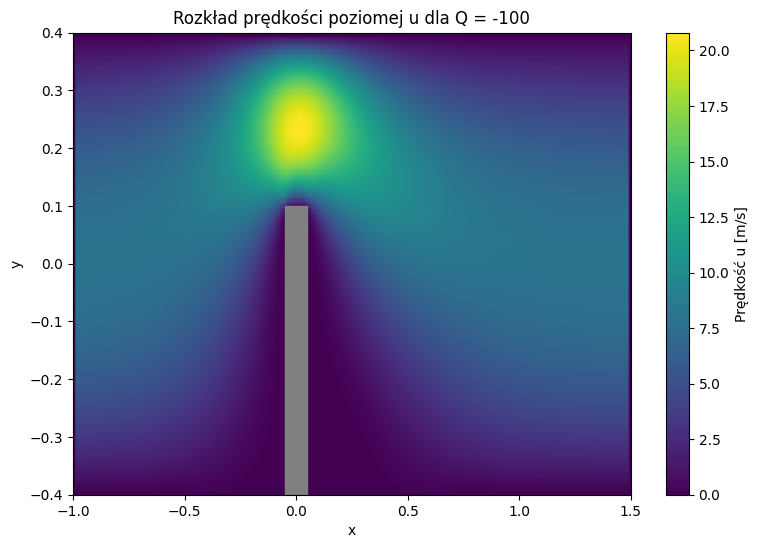

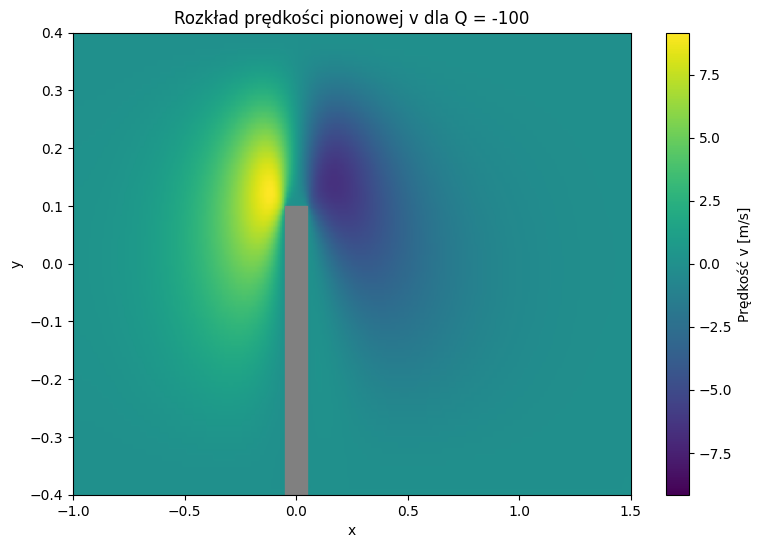


--- Rozpoczynanie symulacji dla Q = -200 ---
Iteracja: 1000, Zmiana: 3.79e-04


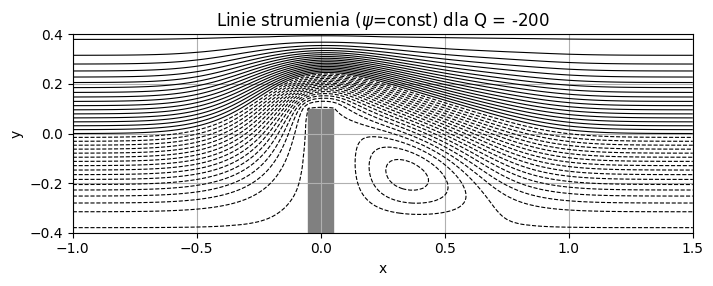

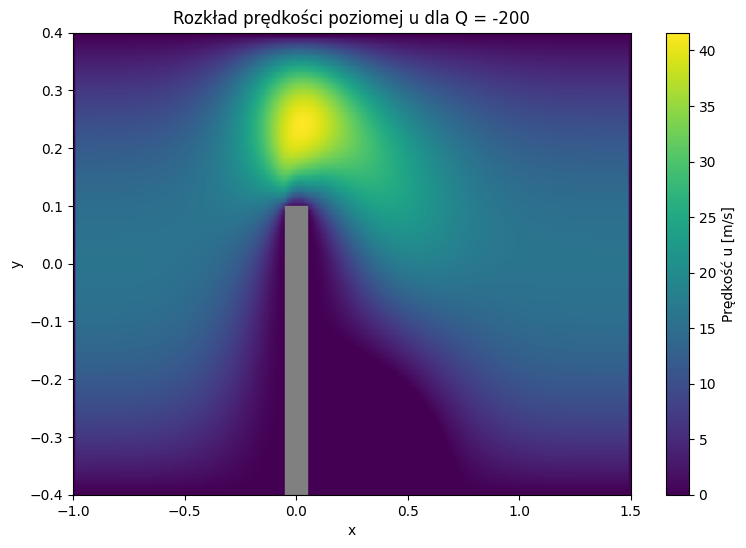

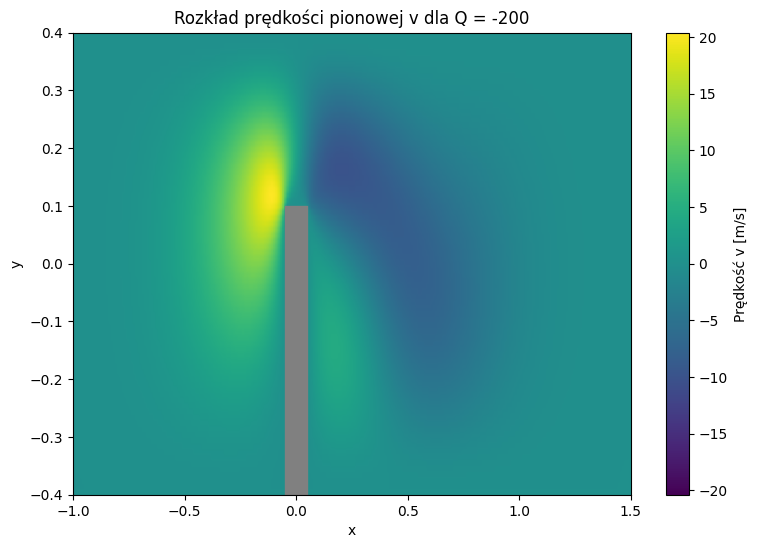


--- Rozpoczynanie symulacji dla Q = -400 ---
Iteracja: 1000, Zmiana: 1.66e-03


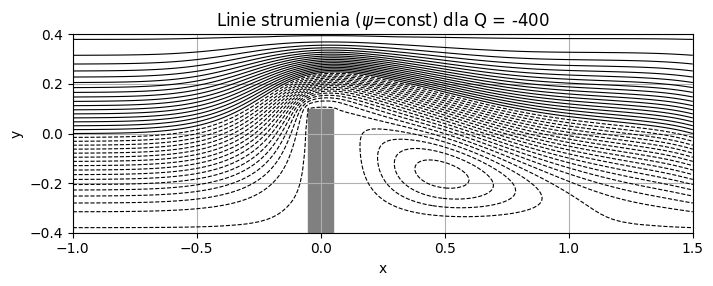

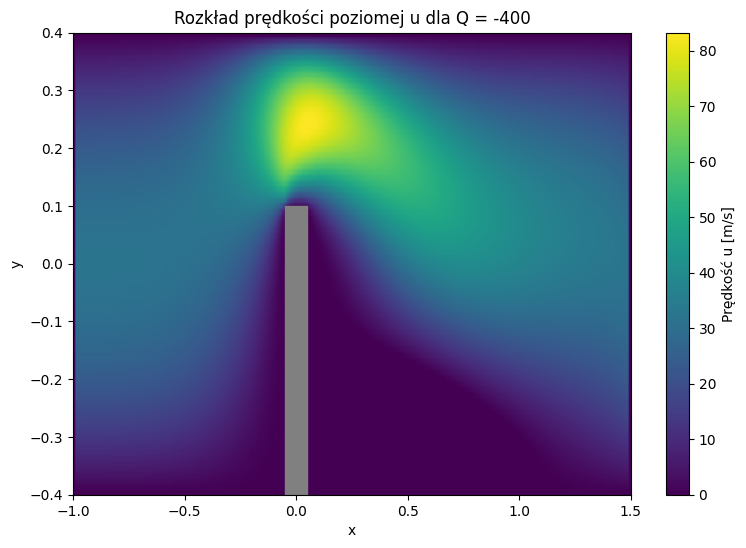

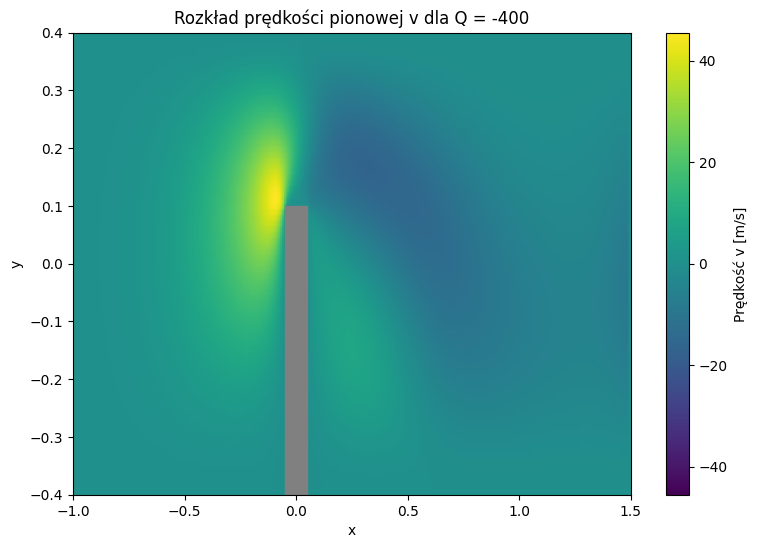

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Parametry
NX, NY = 251, 81
I_OFFSET, J_OFFSET = 100, 40
DZ = 0.01
MU, RHO = 1.0, 1.0
Q_VALUES = [-1, -10, -100, -200, -400]
IK, JK = 5, 10
Y1, Y2 = -40 * DZ, 40 * DZ
MAX_ITER, CONV_TOLERANCE, CHECK_ITER_START = 30000, 1e-6, 500
I_MIN_OBS, I_MAX_OBS, J_MAX_OBS = -IK + I_OFFSET, IK + I_OFFSET, JK + J_OFFSET

# Maska logiczna do pomijania zastawki
is_fluid = np.full((NX, NY), True, dtype=bool)
is_fluid[I_MIN_OBS:I_MAX_OBS+1, :J_MAX_OBS+1] = False
is_fluid_interior = is_fluid[1:-1, 1:-1] # Maska dla samego wnętrza

# Funkcje analityczne
def psi_analytic(y, q_val): return (q_val / (2 * MU)) * (y**3 / 3 + Y1 * Y2 * y)
def zeta_analytic(y, q_val): return (q_val / MU) * y

# Pętla po Q
for Q in Q_VALUES:
    print(f"\n--- Rozpoczynanie symulacji dla Q = {Q} ---")
    
    psi = np.zeros((NX, NY))
    zeta = np.zeros((NX, NY))
    y_grid = (np.arange(NY) - J_OFFSET) * DZ
    for i in range(NX):
        psi[i, :] = psi_analytic(y_grid, Q)
        zeta[i, :] = zeta_analytic(y_grid, Q)
    psi_bottom_val = psi_analytic(Y1, Q)

    for it in range(MAX_ITER):
        psi_old_check = psi[50 + I_OFFSET, 20 + J_OFFSET]
        
        # Aktualizacja warunków brzegowych
        psi[:, 0] = psi_bottom_val
        psi[I_MIN_OBS:I_MAX_OBS + 1, :J_MAX_OBS + 1] = psi_bottom_val
        zeta[:, NY-1] = 2 * (psi[:, NY-2] - psi[:, NY-1]) / DZ**2
        zeta[I_MAX_OBS+1:, 0] = 2 * (psi[I_MAX_OBS+1:, 1] - psi[I_MAX_OBS+1:, 0]) / DZ**2
        zeta[:I_MIN_OBS, 0] = 2 * (psi[:I_MIN_OBS, 1] - psi[:I_MIN_OBS, 0]) / DZ**2
        zeta[I_MIN_OBS, :J_MAX_OBS+1] = 2 * (psi[I_MIN_OBS-1, :J_MAX_OBS+1] - psi[I_MIN_OBS, :J_MAX_OBS+1]) / DZ**2
        zeta[I_MAX_OBS, :J_MAX_OBS+1] = 2 * (psi[I_MAX_OBS+1, :J_MAX_OBS+1] - psi[I_MAX_OBS, :J_MAX_OBS+1]) / DZ**2
        zeta[I_MIN_OBS:I_MAX_OBS+1, J_MAX_OBS] = 2 * (psi[I_MIN_OBS:I_MAX_OBS+1, J_MAX_OBS+1] - psi[I_MIN_OBS:I_MAX_OBS+1, J_MAX_OBS]) / DZ**2
        
        # Optymalizacja
        psin = psi.copy()
        zetan = zeta.copy()

        psi_update = 0.25 * (psi[2:, 1:-1] + psi[:-2, 1:-1] + psi[1:-1, 2:] + psi[1:-1, :-2] - zeta[1:-1, 1:-1] * DZ**2)
        
        term_psi_y = psi[1:-1, 2:] - psi[1:-1, :-2]
        term_zeta_x = zeta[2:, 1:-1] - zeta[:-2, 1:-1]
        term_psi_x = psi[2:, 1:-1] - psi[:-2, 1:-1]
        term_zeta_y = zeta[1:-1, 2:] - zeta[1:-1, :-2]
        zeta_update = 0.25 * (zeta[2:, 1:-1] + zeta[:-2, 1:-1] + zeta[1:-1, 2:] + zeta[1:-1, :-2]) - (RHO / (16 * MU)) * (term_psi_y * term_zeta_x - term_psi_x * term_zeta_y)
        
        # Zastosowanie maski
        psin[1:-1, 1:-1][is_fluid_interior] = psi_update[is_fluid_interior]
        zetan[1:-1, 1:-1][is_fluid_interior] = zeta_update[is_fluid_interior]
        
        psi, zeta = psin, zetan

        if it > CHECK_ITER_START:
            delta = abs(psi[50 + I_OFFSET, 20 + J_OFFSET] - psi_old_check)
            if it % 1000 == 0: print(f"Iteracja: {it}, Zmiana: {delta:.2e}")
            if delta < CONV_TOLERANCE and it > 1000: break
    
    # Obliczenie pól prędkości
    u, v = np.zeros_like(psi), np.zeros_like(psi)
    u[1:-1, 1:-1] = (psi[1:-1, 2:] - psi[1:-1, :-2]) / (2 * DZ)
    v[1:-1, 1:-1] = -(psi[2:, 1:-1] - psi[:-2, 1:-1]) / (2 * DZ)
    x_coords = (np.arange(NX) - I_OFFSET) * DZ
    y_coords = (np.arange(NY) - J_OFFSET) * DZ
    
    # Wykres 1: Linie strumienia
    plt.figure(figsize=(8, 6))
    ax1 = plt.gca()
    ax1.contour(x_coords, y_coords, psi.T, levels=40, colors='k', linewidths=0.8)
    ax1.fill_between(x_coords[I_MIN_OBS:I_MAX_OBS+1], Y1, y_coords[J_MAX_OBS], color='gray')
    ax1.set_title(f'Linie strumienia ($\psi$=const) dla Q = {Q}')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.show()

    # Wykres 2: Prędkość pozioma u
    plt.figure(figsize=(9, 6))
    ax2 = plt.gca()
    vmax_u = np.max(np.abs(u))
    im_u = ax2.imshow(u.T, origin='lower', aspect='auto', cmap='viridis', extent=[x_coords[0], x_coords[-1], Y1, Y2], vmin=0, vmax=vmax_u)
    ax2.fill_between(x_coords[I_MIN_OBS:I_MAX_OBS+1], Y1, y_coords[J_MAX_OBS], color='gray')
    ax2.set_title(f'Rozkład prędkości poziomej u dla Q = {Q}')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    plt.colorbar(im_u, ax=ax2, label='Prędkość u [m/s]')
    plt.show()

    # Wykres 3: Prędkość pionowa v
    plt.figure(figsize=(9, 6))
    ax3 = plt.gca()
    vmax_v = np.max(np.abs(v))
    im_v = ax3.imshow(v.T, origin='lower', aspect='auto', cmap='viridis', extent=[x_coords[0], x_coords[-1], Y1, Y2], vmin=-vmax_v, vmax=vmax_v)
    ax3.fill_between(x_coords[I_MIN_OBS:I_MAX_OBS+1], Y1, y_coords[J_MAX_OBS], color='gray')
    ax3.set_title(f'Rozkład prędkości pionowej v dla Q = {Q}')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    plt.colorbar(im_v, ax=ax3, label='Prędkość v [m/s]')
    plt.show()